In [1]:
# Import Library
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pydot
import time
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.tree import export_graphviz

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from helper_functions import *

In [3]:
#Import Dataset
df = pd.read_csv("datamita.csv")
df.head()

,T,RH,TOW,Prec,SO2,H+,CR
0,9.5,79,2830,639.3,77.5,0.0000,14.89
1,10.3,74,2555,380.8,58.1,0.0221,6.98
2,9.1,73,2627,684.3,41.2,0.0714,7.78
3,9.8,77,3529,581.1,32.1,0.0342,5.69
4,7.0,77,3011,850.2,19.7,0.0000,8.95


In [4]:
#Define Features and Target
feature= df.drop('CR', axis=1)
target= df['CR']
feature

,T,RH,TOW,Prec,SO2,H+
0,9.5,79,2830,639.3,77.5,0.0000
1,10.3,74,2555,380.8,58.1,0.0221
2,9.1,73,2627,684.3,41.2,0.0714
3,9.8,77,3529,581.1,32.1,0.0342
4,7.0,77,3011,850.2,19.7,0.0000
...,...,...,...,...,...,...
166,-0.7,76,0,558.0,10.0,0.0000
167,-15.5,68,0,306.0,3.0,0.0000
168,-0.4,71,0,403.0,4.0,0.0000
169,5.0,79,0,570.0,14.0,0.0000


In [5]:
feature

,T,RH,TOW,Prec,SO2,H+
0,9.5,79,2830,639.3,77.5,0.0000
1,10.3,74,2555,380.8,58.1,0.0221
2,9.1,73,2627,684.3,41.2,0.0714
3,9.8,77,3529,581.1,32.1,0.0342
4,7.0,77,3011,850.2,19.7,0.0000
...,...,...,...,...,...,...
166,-0.7,76,0,558.0,10.0,0.0000
167,-15.5,68,0,306.0,3.0,0.0000
168,-0.4,71,0,403.0,4.0,0.0000
169,5.0,79,0,570.0,14.0,0.0000


In [6]:
target

0      14.89
1       6.98
2       7.78
3       5.69
4       8.95
       ...  
166     6.35
167     1.24
168     3.84
169     7.41
170     7.03
Name: CR, Length: 171, dtype: float64

In [7]:
X = feature                         # inputs/features 
y = target # outputs/targets

In [8]:
seed = 726

In [9]:
# Generate train/test split by reserving 30% of data as test set
from sklearn.model_selection import train_test_split

test_fraction = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fraction, shuffle=True,random_state=seed)

In [10]:
Default_model = XGBRegressor(random_state=seed,n_estimators=1,learning_rate=0.05).fit(X_train,y_train) # fit the decision tree model
print('Model training complete.')
# print('Tree depth:', [estimator.tree_.max_depth for estimator in Default_model.estimators_])
# for importance in zip (estimator.feature_importances_ for estimator in Default_model.estimators_):
#     print (importance)
#print('Leaf nodes:',[estimator.tree_.n_leaves for estimator in Default_model.estimators_])

Model training complete.


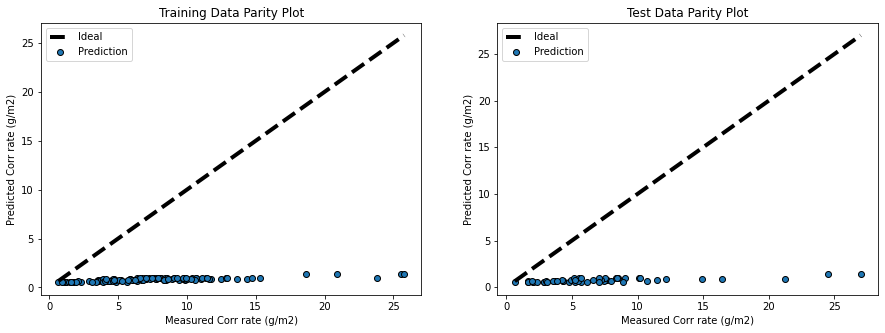

,Error Metric,Training Data,Test Data,Note
0,RMSE,7.9278 (g/m2),8.2813 (g/m2),(0.0 for perfect prediction)
1,RMSE/std,1.6848,1.5294,(0.0 for perfect prediction)
2,MAE,6.4882 (g/m2),6.3928 (g/m2),(0.0 for perfect prediction)
3,R2,-1.8385,-1.3391,(1.0 for perfect prediction)


In [11]:
Train_predictions = Default_model.predict(X_train)    # Make predictions on training data
Test_predictions = Default_model.predict(X_test)      # Make predictions on testing data

parity_plots_side_by_side(y_train,Train_predictions,y_test,Test_predictions,title_left="Training Data Parity Plot",title_right="Test Data Parity Plot") # build both plots
parity_stats_side_by_side(y_train,Train_predictions,y_test,Test_predictions,"Training Data","Test Data")  # print error metrics for training data

# IMPROVING THE MODEL BY OPTIMIZING HYPERPARAMETERS

In [12]:
print('Default model uses the following hyperparameters:\n') # print default hyperparameters used
print(Default_model.get_params())

Default model uses the following hyperparameters:

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 726, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [13]:
# set up hyperparameter grid (a dictionary of hyperparameter candidates that we want the optimization strategy to consider)

# EDIT LIST TO TRY DIFFERENT VALUES!
### MAKE EDITS BELOW HERE ###

number_of_trees = [1,10,25,50,100,200,300]

### MAKE EDITS ABOVE HERE ###

opt_dict = {'n_estimators':number_of_trees}

In [14]:
# kfold = KFold(n_splits=5,random_state=seed,shuffle=True)
kfold = KFold(n_splits=10,
                      random_state=seed,
                      shuffle=True)

In [15]:
# define a grid search strategy

import time

CV = GridSearchCV(Default_model, # 1. the model whose hyperparamter is being optimized right now
                  opt_dict,   # 2. a dictionary of values that we want the grid search to use
                  cv=kfold,   # 4. k-fold cross-validation strategy is used to define training and validation splits (note this is separate from test splits) to be used for each grid point
                  return_train_score=True,
                  scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'], # 5. the performance metrics to be reported at each grid point specified in opt_dict
                  refit='neg_mean_squared_error')

# perform grid search
tic = time.perf_counter() # start timer

CV = CV.fit(X_train,y_train)

toc = time.perf_counter() # stop timer

# print results
print(f"Grid search completed in {toc - tic:0.3f} seconds.")
print(CV.best_params_)

Grid search completed in 16.108 seconds.
{'n_estimators': 100}


# VISUALIZING THE LEARNING CURVE

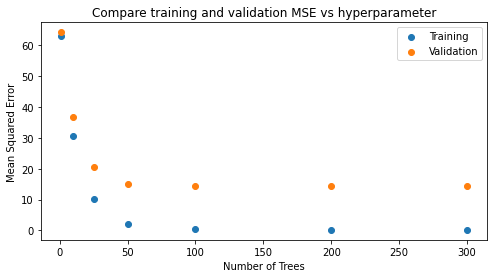

Minimum Mean Squared Error:  14.2352
Number of Trees at minimum:  100


In [16]:
# plot number of trees vs train and test MSE

opt_dict_array = opt_dict["n_estimators"]                     # array of grid points (x-axis)
train_mse = CV.cv_results_["mean_train_neg_mean_squared_error"] # MSE of training set at each grid point (y-axis)
test_mse = CV.cv_results_["mean_test_neg_mean_squared_error"]   # MSE of test set at each grid point (y-axis)

fig1,ax1 = plt.subplots(figsize=(8,4))
ax1.scatter(opt_dict_array, -train_mse)
ax1.scatter(opt_dict_array, -test_mse)
# ax1.fill_between(opt_dict_array, -train_mse, -test_mse, alpha=0.1)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Compare training and validation MSE vs hyperparameter')
plt.legend(["Training","Validation","difference"])
plt.show()
print("Minimum Mean Squared Error: ", round(min(-test_mse),4))
print("Number of Trees at minimum: ", opt_dict_array[np.argmin(-test_mse)])

In [17]:
# check what the best parameters identified in the grid search were
CV.best_params_

{'n_estimators': 100}

In [18]:
# Extract cross validation performance metrics for the optimized model
opt_CV_stats = CV_best_stats(CV,y_train)

Average test RMSE:  3.773 (0.0 for perfect prediction)
Average test RMSE/std:  0.8018 (0.0 for perfect prediction)
Average test MAE:  2.5765 (0.0 for perfect prediction)
Average test R2:  -0.2203 (1.0 for perfect prediction)


In [19]:
default_opt_dict = {'n_estimators':[1]}

default_CV = GridSearchCV(Default_model,
                          default_opt_dict,
                          cv=kfold,
                          return_train_score=True,
                          scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'],
                          refit='neg_mean_squared_error')
default_CV = default_CV.fit(X_train,y_train)

default_CV_stats = CV_best_stats(default_CV,y_train)

Average test RMSE:  8.0106 (0.0 for perfect prediction)
Average test RMSE/std:  1.7024 (0.0 for perfect prediction)
Average test MAE:  6.527 (0.0 for perfect prediction)
Average test R2:  -2.7698 (1.0 for perfect prediction)


# DEFAULT VS. OPTIMIZED MODEL: TRAINING AND TEST DATA PERFORMANCE

In [20]:
# Refit the model using the best hyperparameters
DT2 = CV.best_estimator_.fit(X_train,y_train)

# predict both the train and test data
Train_predictions2 = DT2.predict(X_train)
Test_predictions2 = DT2.predict(X_test)

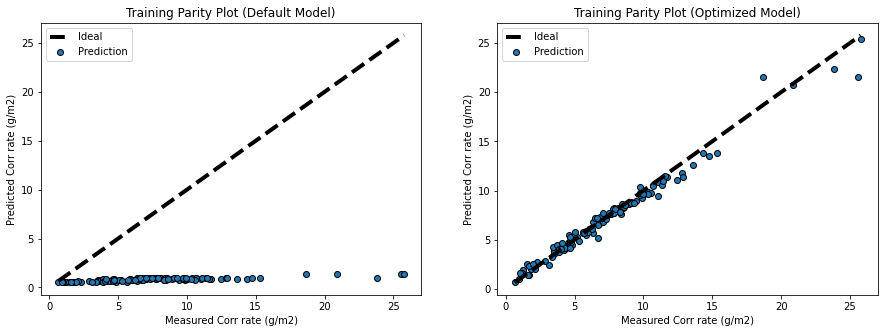

,Error Metric,Training Set (Default Model),Training Set (Optimized Model),Note
0,RMSE,7.9278 (g/m2),0.71 (g/m2),(0.0 for perfect prediction)
1,RMSE/std,1.6848,0.1509,(0.0 for perfect prediction)
2,MAE,6.4882 (g/m2),0.4613 (g/m2),(0.0 for perfect prediction)
3,R2,-1.8385,0.9772,(1.0 for perfect prediction)


In [21]:
parity_plots_side_by_side(y_train,Train_predictions,y_train,Train_predictions2,title_left="Training Parity Plot (Default Model)",title_right="Training Parity Plot (Optimized Model)") # build both plots
parity_stats_side_by_side(y_train,Train_predictions,y_train,Train_predictions2,"Training Set (Default Model)","Training Set (Optimized Model)")

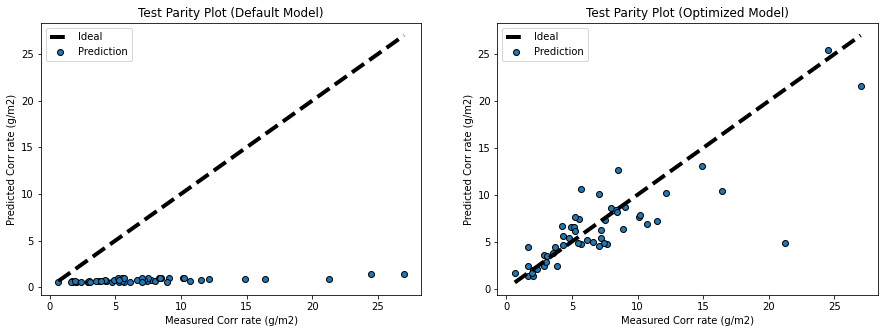

,Error Metric,Test Set (Default Model),Test Set (Optimized Model),Note
0,RMSE,8.2813 (g/m2),3.1355 (g/m2),(0.0 for perfect prediction)
1,RMSE/std,1.5294,0.5791,(0.0 for perfect prediction)
2,MAE,6.3928 (g/m2),1.9155 (g/m2),(0.0 for perfect prediction)
3,R2,-1.3391,0.6647,(1.0 for perfect prediction)


In [22]:
parity_plots_side_by_side(y_test,Test_predictions,y_test,Test_predictions2, title_left="Test Parity Plot (Default Model)",title_right="Test Parity Plot (Optimized Model)") # build both plots
parity_stats_side_by_side(y_test,Test_predictions,y_test,Test_predictions2,"Test Set (Default Model)","Test Set (Optimized Model)")

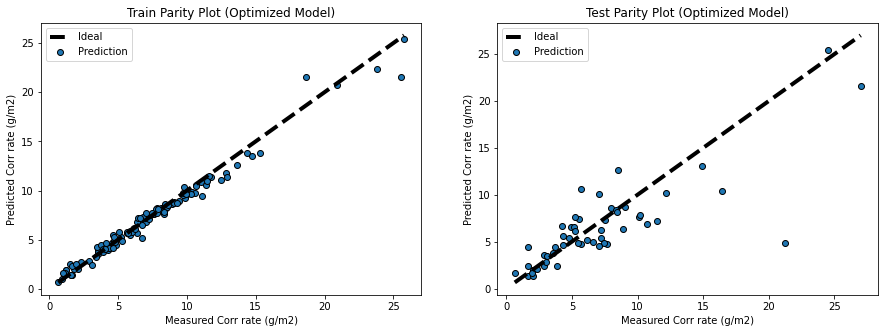

In [23]:
parity_plots_side_by_side(y_train,Train_predictions2,y_test,Test_predictions2, title_left="Train Parity Plot (Optimized Model)",title_right="Test Parity Plot (Optimized Model)") # build both plots

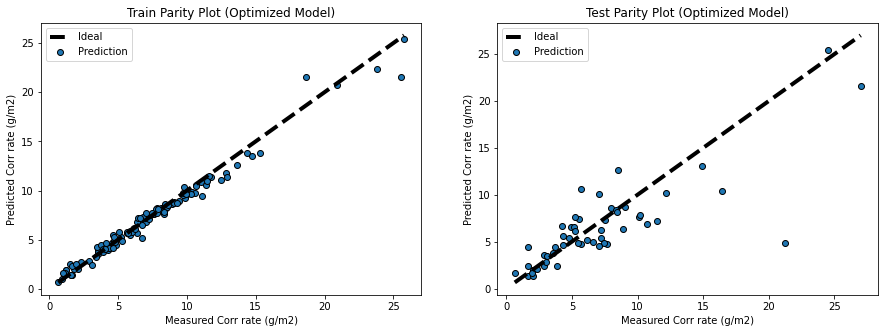

In [24]:
parity_plots_side_by_side(y_train,Train_predictions2,y_test,Test_predictions2, title_left="Train Parity Plot (Optimized Model)",title_right="Test Parity Plot (Optimized Model)") # build both plots

In [25]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

In [26]:
layout0= go.Layout(title= r'$ \text{ XGB Regressor } $', hovermode= 'closest',
                       font = dict(family='Times New Roman',size=18),
                       xaxis= dict(title= 'Measured Corr Rate (g/m2)',zeroline= False, gridwidth= 2),
                       yaxis= dict(title= 'Predicted Corr Rate (g/m2)',zeroline= False, gridwidth= 2),#range=[-350,3750]),
                       #height=1000,
                       #width=1000,
         showlegend= True )


In [27]:
    fit = np.linspace(min(target), max(target))
    trace0 = go.Scatter(x=y_train, y=Train_predictions2, mode = 'markers', marker= dict(size= 12, color= 'blue'), name='Training Data')
    trace1 = go.Scatter(x=y_test ,y=Test_predictions2, mode = 'markers', marker= dict(size= 12, color= 'red'),name='Testing Data')
    trace2 = go.Scatter(x = fit ,y = fit, mode = 'lines', marker= dict(size= 12, color= 'black'), text = 'Fit',name='Linear Fit')

    data = [trace0,trace1,trace2]
    fig= go.Figure(data, layout=layout0)
    resolution_value = 300
    iplot(fig)

# Predicting Corr Rate for New Location

In [28]:
Test_predictions2 = DT2.predict(X_test)

In [29]:
print('Test based on dataset No.1')
dataset_1=pd.DataFrame({'T':[9.5], 'RH':[79],'TOW':[2830], 'Prec':[639.3], 'SO2':[77.5], 'H+':[0]})
dataset_1

Test based on dataset No.1


,T,RH,TOW,Prec,SO2,H+
0,9.5,79,2830,639.3,77.5,0


In [30]:
print('Test based on dataset No.1 CR = 14.89 g/m2')
Test_predictions2 = DT2.predict(dataset_1)
print('CR with model predict dataset_1:', Test_predictions2, 'g/m2')

Test based on dataset No.1 CR = 14.89 g/m2
CR with model predict dataset_1: [13.059686] g/m2


In [31]:
print('Test based on dataset No.30')
dataset_30=pd.DataFrame({'T':[10.7], 'RH':[79],'TOW':[4437], 'Prec':[619.1], 'SO2':[16.3], 'H+':[0.0291]})
dataset_30

Test based on dataset No.30


,T,RH,TOW,Prec,SO2,H+
0,10.7,79,4437,619.1,16.3,0.0291


In [32]:
print('Test based on dataset No.30 CR = 9.07 g/m2')
Test_predictions2  = DT2.predict(dataset_30)
print('CR with model predict dataset_30:', Test_predictions2 , 'g/m2')

Test based on dataset No.30 CR = 9.07 g/m2
CR with model predict dataset_30: [8.7453] g/m2


In [33]:
print('Test based on dataset No.50')
dataset_50=pd.DataFrame({'T':[11.1], 'RH':[82],'TOW':[5142], 'Prec':[789.9], 'SO2':[5.8], 'H+':[0.0038]})
dataset_50

Test based on dataset No.50


,T,RH,TOW,Prec,SO2,H+
0,11.1,82,5142,789.9,5.8,0.0038


In [34]:
print('Test based on dataset No.50 CR = 6.34 g/m2')
Test_predictions2  = DT2.predict(dataset_50)
print('CR with model predict dataset_30:', Test_predictions2 , 'g/m2')

Test based on dataset No.50 CR = 6.34 g/m2
CR with model predict dataset_30: [6.840483] g/m2


In [35]:
print('Test based on dataset No.165')
dataset_165=pd.DataFrame({'T':[2.5], 'RH':[70],'TOW':[0], 'Prec':[626], 'SO2':[3], 'H+':[0]})
dataset_165

Test based on dataset No.165


,T,RH,TOW,Prec,SO2,H+
0,2.5,70,0,626,3,0


In [36]:
print('Test based on dataset No.165 CR = 4.64 g/m2')
Test_predictions2  = DT2.predict(dataset_165)
print('CR with model predict dataset_30:', Test_predictions2 , 'g/m2')

Test based on dataset No.165 CR = 4.64 g/m2
CR with model predict dataset_30: [4.1450195] g/m2


In [37]:
#Table S2. New data to be used as validation
#Location	T(oC)	RH(%)	TOW(Hours/a)	Prec(mm/a)	SO2(µg/m3)	[H+](mg/L)	CR(g/m2)
#Panama	26	71	3000	279	21.7	0	7.568
#Rio Janeiro	21.4	80	4800	1252	43.5	0	10.496
#Iguazu	21.2	75	5500	1000	0	0	9.710
#Sao Paulo	19.6	75	5500	1622	57.8	0	8.639
#Bauta	24	81	5000	1590	18	0	8.711
#Labastida	12	73	5500	550	3.6	0	2.213
#Mexico	15.4	64	1000	709	18.9	0	5.855


In [38]:
Panama = pd.DataFrame({'T':[26], 'RH':[71],'TOW':[3000], 'Prec':[279], 'SO2':[21.7], 'H+':[0]})
Rio = pd.DataFrame({'T':[21.4], 'RH':[80],'TOW':[4800], 'Prec':[1252], 'SO2':[43.5], 'H+':[0]})
Iguazu = pd.DataFrame({'T':[21.2], 'RH':[75],'TOW':[5500], 'Prec':[1000], 'SO2':[0], 'H+':[0]})
Saopaolo = pd.DataFrame({'T':[19.6], 'RH':[75],'TOW':[5500], 'Prec':[1622], 'SO2':[57.8], 'H+':[0]})
Bauta = pd.DataFrame({'T':[24], 'RH':[81],'TOW':[5000], 'Prec':[1590], 'SO2':[18], 'H+':[0]})
Labastida = pd.DataFrame({'T':[12], 'RH':[73],'TOW':[5500], 'Prec':[550], 'SO2':[3.6], 'H+':[0]})
Mexico = pd.DataFrame({'T':[15.4], 'RH':[64],'TOW':[1000], 'Prec':[709], 'SO2':[18.9], 'H+':[0]})

In [39]:
print('Test based on dataset Panama CR = 7.568 g/m2')
Test_predictions2  = DT2.predict(Panama)
print('CR with model predict dataset_Panama:', Test_predictions2 , 'g/m2')

Test based on dataset Panama CR = 7.568 g/m2
CR with model predict dataset_Panama: [9.56516] g/m2


In [40]:
print('Test based on dataset Rio CR = 10.496 g/m2')
Test_predictions2  = DT2.predict(Rio)
print('CR with model predict dataset_Rio:', Test_predictions2 , 'g/m2')

Test based on dataset Rio CR = 10.496 g/m2
CR with model predict dataset_Rio: [9.190669] g/m2


In [41]:
print('Test based on dataset Iguazu CR = 9.710 g/m2')
Test_predictions2  = DT2.predict(Iguazu)
print('CR with model predict dataset_Iguazo:', Test_predictions2 , 'g/m2')

Test based on dataset Iguazu CR = 9.710 g/m2
CR with model predict dataset_Iguazo: [20.155245] g/m2


In [42]:
print('Test based on dataset Saopaolo CR = 8.639 g/m2')
Test_predictions2  = DT2.predict(Saopaolo)
print('CR with model predict dataset_Saopaolo:', Test_predictions2 , 'g/m2')

Test based on dataset Saopaolo CR = 8.639 g/m2
CR with model predict dataset_Saopaolo: [9.612801] g/m2


In [43]:
print('Test based on dataset Bauta CR = 8.711 g/m2')
Test_predictions2  = DT2.predict(Bauta)
print('CR with model predict dataset_Bauta:', Test_predictions2 , 'g/m2')

Test based on dataset Bauta CR = 8.711 g/m2
CR with model predict dataset_Bauta: [10.674955] g/m2


In [44]:
print('Test based on dataset Labastida CR = 2.213 g/m2')
Test_predictions2  = DT2.predict(Labastida)
print('CR with model predict dataset_Labastida:', Test_predictions2 , 'g/m2')

Test based on dataset Labastida CR = 2.213 g/m2
CR with model predict dataset_Labastida: [3.4964921] g/m2


In [45]:
print('Test based on dataset Mexico CR = 5.855 g/m2')
Test_predictions2  = DT2.predict(Mexico)
print('CR with model predict dataset_Mexico:', Test_predictions2 , 'g/m2')

Test based on dataset Mexico CR = 5.855 g/m2
CR with model predict dataset_Mexico: [6.761529] g/m2


# PREDICTION NEW DATA

In [46]:
#Table S3. New data on corrosion rates at several test locations
#Location	T (oC)	RH (%)	TOW (Hours/a)	Prec (mm/a)	SO2 (µg/m3)	[H+] (mg/L)
#						
#Jakarta, Indonesia	31	65	5500	100	71	0
#Bandung, Indonesia	24	81	3500	999	17	0
#Valparaiso, Chile	17	83	5600	0.1	23.6	0
#Barcelona, Spain	26	78	500	640	1.5	0
#Tokyo, Japan	22	73	29.1	1530	12.4	0


In [47]:
Jakarta = pd.DataFrame({'T':[31], 'RH':[65],'TOW':[5500], 'Prec':[100], 'SO2':[71], 'H+':[0]})
Bandung = pd.DataFrame({'T':[24], 'RH':[81],'TOW':[3500], 'Prec':[999], 'SO2':[17], 'H+':[0]})
Valparaiso = pd.DataFrame({'T':[17], 'RH':[83],'TOW':[5600], 'Prec':[0.1], 'SO2':[23.6], 'H+':[0]})
Barcelona = pd.DataFrame({'T':[26], 'RH':[78],'TOW':[500], 'Prec':[640], 'SO2':[1.5], 'H+':[0]})
Tokyo = pd.DataFrame({'T':[22], 'RH':[73],'TOW':[29.1], 'Prec':[1530], 'SO2':[12.4], 'H+':[0]})

In [48]:
print('Test based on data Jakarta')
Test_predictions2  = DT2.predict(Jakarta)
print('CR with model predict Jakarta:', Test_predictions2 , 'g/m2')

Test based on data Jakarta
CR with model predict Jakarta: [7.5639863] g/m2


In [49]:
print('Test based on data Bandung')
Test_predictions2  = DT2.predict(Bandung)
print('CR with model predict Bandung:', Test_predictions2 , 'g/m2')

Test based on data Bandung
CR with model predict Bandung: [8.490747] g/m2


In [50]:
print('Test based on data Valparaiso')
Test_predictions2  = DT2.predict(Valparaiso)
print('CR with model predict Valparaiso:', Test_predictions2 , 'g/m2')

Test based on data Valparaiso
CR with model predict Valparaiso: [8.405043] g/m2


In [51]:
print('Test based on data Barcelona')
Test_predictions2  = DT2.predict(Barcelona)
print('CR with model predict Barcelona:', Test_predictions2 , 'g/m2')

Test based on data Barcelona
CR with model predict Barcelona: [1.9322647] g/m2


In [52]:
print('Test based on data Tokyo')
Test_predictions2  = DT2.predict(Tokyo)
print('CR with model predict Tokyo:', Test_predictions2 , 'g/m2')

Test based on data Tokyo
CR with model predict Tokyo: [3.7595682] g/m2
